In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dill as pickle
import os
from tensorflow import keras
from keras import models, layers, optimizers, regularizers ,Model
from keras.layers import Input, LSTM, Dense

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Write Methods to Load the Dataset

In [2]:
"""
Inspired by: https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py
"""

import numpy as np

def convert_list_of_arrays_to_padded_array(list_varying_sizes):
    # Determine the maximum shape
    max_shape = [0, 0]
    for arr in list_varying_sizes:
        for i in range(len(arr.shape)):
            if arr.shape[i] > max_shape[i]:
                max_shape[i] = arr.shape[i]
    
    # Ensure max_shape has at least two dimensions
    if len(max_shape) < 2:
        max_shape.append(1)
    
    padded_array = np.zeros((len(list_varying_sizes), *max_shape))

    # Second pass to fill in the values in the array:
    for a, arr in enumerate(list_varying_sizes):
        if len(arr.shape) == 1:
            arr = arr.reshape(-1, 1)  # Reshape 1D array to 2D
        r, c = arr.shape  # Ensure arr is 2D
        padded_array[a, :r, :c] = arr

    return padded_array

def preprocess_encoder_input(arr):
    '''
    Simple method to handle the complex MFCC coefs that are produced during preprocessing. This means:
    1. (For now), discarding one of the channels of the MFCC coefs
    2. Collapsing any empty dimensions
    '''
    return arr.squeeze()[0]


# Load every one-hot-encoded output as a dictionary
with open('one-hot.pkl', 'rb') as one_hot_quran_pickle_file:
    one_hot_obj = pickle.load(one_hot_quran_pickle_file)


def get_one_hot_encoded_verse(surah_num, ayah_num): 
    '''
    Converts a one-hot-encoded verse into forms that can be used by the LSTM decoder
    
    :param surah_num: an int designating the chapter number, one-indexed
    :param ayah_num: an int designating the verse number, one-indexed
    '''
    # Load the preprocessed one-hot encoding 
    one_hot_verse = one_hot_obj['quran']['surahs'][surah_num - 1]['ayahs'][ayah_num - 1]['text']
    num_chars_in_verse, num_unique_chars = one_hot_verse.shape
    
    print(f"Number of characters in verse: {num_chars_in_verse} and number of unique characters: {num_unique_chars}")
    
    # Generate decoder_input_data 
    decoder_input = np.zeros((num_chars_in_verse+2, num_unique_chars+2))
    decoder_input[0, :] = [0] * num_unique_chars + [1, 0] # START token
    decoder_input[1:num_chars_in_verse+1, :-2] = one_hot_verse # original verse
    decoder_input[-1, :] = [0] * num_unique_chars + [0, 1] # STOP token

    # Generate decoder_target_data 
    decoder_target = np.zeros((num_chars_in_verse+2, num_unique_chars+2))
    decoder_target[:num_chars_in_verse, :-2] = one_hot_verse # original verse
    decoder_target[-2, :] = [0] * num_unique_chars + [0, 1] # STOP token
    
    return decoder_input, decoder_target

    
def build_dataset(local_coefs_dir='word_by_word_mfcc/alafasy', surahs=[1], n=100):
    '''
    Builds a dataset to be used with the sequence-to-sequence network.
    
    :param local_coefs_dir: a string with the path of the coefficients for prediction
    '''
    
    def get_encoder_and_decoder_data(n=100):
        count = 0
        encoder_input_data = []
        decoder_input_data = []
        decoder_target_data = []
        for surah_num in surahs:
            local_surah_dir = os.path.join(local_coefs_dir, "s" + str(surah_num))
            for _, ayah_directories, _ in os.walk(local_surah_dir):
                for ayah_directory in ayah_directories:
                    ayah_num = ayah_directory[1:]
                    local_ayah_dir = os.path.join(local_surah_dir, ayah_directory)
                    for _, _, recording_filenames in os.walk(local_ayah_dir):
                        for recording_filename in recording_filenames:
                            local_coefs_path = os.path.join(local_ayah_dir, recording_filename)
                            encoder_input = np.load(local_coefs_path)
                            encoder_input = preprocess_encoder_input(encoder_input)
                            encoder_input_data.append(encoder_input)

                            decoder_input, decoder_target = get_one_hot_encoded_verse(int(surah_num), int(ayah_num))
                            decoder_input_data.append(decoder_input)
                            decoder_target_data.append(decoder_target)
                            count += 1
                            if count == n:
                                return encoder_input_data, decoder_input_data, decoder_target_data
        return encoder_input_data, decoder_input_data, decoder_target_data
    
    
    encoder_input_data, decoder_input_data, decoder_target_data = get_encoder_and_decoder_data(n=n)
    encoder_input_data = convert_list_of_arrays_to_padded_array(encoder_input_data)
    decoder_input_data = convert_list_of_arrays_to_padded_array(decoder_input_data)
    decoder_target_data = convert_list_of_arrays_to_padded_array(decoder_target_data)
    return encoder_input_data, decoder_input_data, decoder_target_data

In [3]:
batch_size = 10  # Batch size for training.
epochs = 25  # Number of epochs to train for.
latent_dim = 10  # Latent dimensionality of the encoding space.
n = 100

encoder_input_data, decoder_input_data, decoder_target_data = build_dataset(n=n)
print(encoder_input_data.shape)

Number of characters in verse: 38 and number of unique characters: 59
Number of characters in verse: 38 and number of unique characters: 59
Number of characters in verse: 38 and number of unique characters: 59
Number of characters in verse: 38 and number of unique characters: 59
Number of characters in verse: 37 and number of unique characters: 59
Number of characters in verse: 37 and number of unique characters: 59
Number of characters in verse: 37 and number of unique characters: 59
Number of characters in verse: 37 and number of unique characters: 59
Number of characters in verse: 23 and number of unique characters: 59
Number of characters in verse: 23 and number of unique characters: 59
Number of characters in verse: 23 and number of unique characters: 59
Number of characters in verse: 23 and number of unique characters: 59
Number of characters in verse: 23 and number of unique characters: 59
Number of characters in verse: 40 and number of unique characters: 59
Number of characters

In [4]:
[print(a.shape) for a in [encoder_input_data, decoder_input_data, decoder_target_data]]

max_encoder_seq_length = encoder_input_data.shape[1]
max_decoder_seq_length = decoder_input_data.shape[1]
num_encoder_tokens = encoder_input_data.shape[-1]
num_decoder_tokens = decoder_input_data.shape[-1]
print(num_decoder_tokens)



(28, 13, 0)
(28, 92, 61)
(28, 92, 61)
61


### Build a Keras Model for Training

In [5]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [6]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
              batch_size=batch_size,
              epochs=epochs,
              validation_split=0.2)

Epoch 1/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 1.7196 - val_loss: 4.0575
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.6811 - val_loss: 4.0498
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.8494 - val_loss: 4.0450
Epoch 4/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.7797 - val_loss: 4.0405
Epoch 5/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.8516 - val_loss: 4.0356
Epoch 6/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.7581 - val_loss: 4.0286
Epoch 7/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.7923 - val_loss: 4.0223
Epoch 8/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.7508 - val_loss: 4.0125
Epoch 9/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.8573 - val_loss: 4.0025
Epoch 10/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.7554 - val_loss: 3.9871
Epoch 11/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.7600 - val_loss: 3.9708
Epoch 12/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.6420 - val_loss: 3.9477


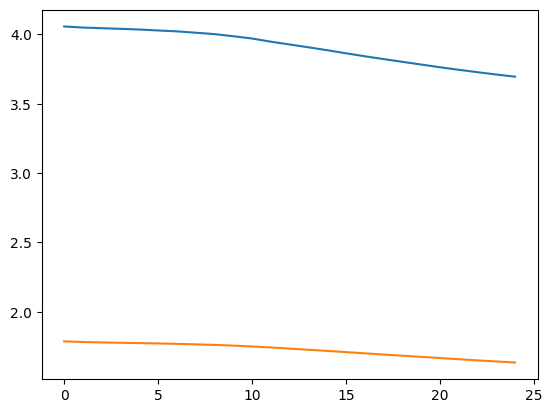

In [7]:
plt.plot(range(epochs), history.history['val_loss'])
plt.plot(range(epochs), history.history['loss'])

The drop in loss curves suggest that the model is learning something. At this point, it hasn't overfit to the validation set, likely because our model is too simple. 

### Build Inference Model

In [8]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [9]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_target_char_index = one_hot_obj['int_to_char']
reverse_target_char_index[num_decoder_tokens-2] = '->'
reverse_target_char_index[num_decoder_tokens-1] = '<-'

target_char_index = {v: k for k, v in reverse_target_char_index.items()}

In [10]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_char_index['->']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '<-' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(10):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('Predicted verse:', decoded_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━